# September Tabular Competition


The dataset for this month incorporates more than 1.45 million rows of data. Since some of that data is missing - 936218 elements from the test set and 1820782 from train set, there is an option to fill those NA values. To underline how these missing values impact the dataset as a whole:


$N_{joint}$ = $\texttt{number of elements in the joint set} $

$m_{joint}$ = $\texttt{number of missing elements in the joint set} $

\begin{equation}
    \frac{m_{joint}}{N_{joint}} \,= \frac{sum(is.na(test)) + sum(is.na(train))}{118 * nrow(train + test)} \, = \frac{2757000}{171264374} \, = 0.016098 \\
\end{equation}


Missing cells make up a little more than 1.6% of joint datasets. Due to the nature of how missing cells affect whole rows, trimmed dataset has only 545157 rows (37.5% of original size).

General idea for this notebook is preprocessing, exploring missing values (how many missing values are in a row), filling them and creating a neural network / rf for classification.

Some features in the dataset consist of huge numbers and are in need of transformation before imputing missing values.




Since the dataset is massive, control of RAM usage is very important.

In [1]:
#Loading in libraries
pacman::p_load(tidyverse, dplyr, keras, tensorflow, ggplot2, ggthemes, fastDummies, janitor, cowplot,
                repr, BBmisc, devtools, reticulate, Rcpp,  cvAUC, tictoc)

#Loading in data
df_train <- read.csv("../input/tabular-playground-series-sep-2021/train.csv")
df_test <- read.csv("../input/tabular-playground-series-sep-2021/test.csv")

In [2]:
py_discover_config()

python:         /miniconda/envs/r-reticulate/bin/python
libpython:      /miniconda/envs/r-reticulate/lib/libpython3.7m.so
pythonhome:     /miniconda/envs/r-reticulate:/miniconda/envs/r-reticulate
version:        3.7.11 (default, Jul 27 2021, 14:32:16)  [GCC 7.5.0]
numpy:          /miniconda/envs/r-reticulate/lib/python3.7/site-packages/numpy
numpy_version:  1.18.5

python versions found: 
 /miniconda/envs/r-reticulate/bin/python
 /usr/bin/python3
 /usr/bin/python

'h2o4gpu' package requires an installed python module. First the package is downloaded using a  *install_github()* function from devtools and then python module is installed using a *py_install()* function from the reticulate package.

In [3]:
#Loading in h2o4gpu package
devtools::install_github("h2oai/h2o4gpu", subdir = "src/interface_r")
library(h2o4gpu)


'/usr/bin/git' clone --depth 1 --no-hardlinks --recurse-submodules https://github.com/h2oai/cub /tmp/RtmpziXP6j/remotesf6fdf36ef/h2oai-h2o4gpu-aaf7795/src/interface_r/../../cub

'/usr/bin/git' clone --depth 1 --no-hardlinks --recurse-submodules https://github.com/h2oai/xgboost /tmp/RtmpziXP6j/remotesf6fdf36ef/h2oai-h2o4gpu-aaf7795/src/interface_r/../../xgboost

'/usr/bin/git' clone --depth 1 --no-hardlinks --recurse-submodules https://github.com/h2oai/py3nvml /tmp/RtmpziXP6j/remotesf6fdf36ef/h2oai-h2o4gpu-aaf7795/src/interface_r/../../py3nvml

'/usr/bin/git' clone --depth 1 --no-hardlinks --recurse-submodules https://github.com/h2oai/scikit-learn.git /tmp/RtmpziXP6j/remotesf6fdf36ef/h2oai-h2o4gpu-aaf7795/src/interface_r/../../scikit-learn

'/usr/bin/git' clone --depth 1 --no-hardlinks --recurse-submodules https://github.com/google/googletest.git /tmp/RtmpziXP6j/remotesf6fdf36ef/h2oai-h2o4gpu-aaf7795/src/interface_r/../../tests/googletest

'/usr/bin/git' clone --depth 1 --no-hardlinks 


✔  checking for file ‘/tmp/RtmpziXP6j/remotesf6fdf36ef/h2oai-h2o4gpu-aaf7795/src/interface_r/DESCRIPTION’
─  preparing ‘h2o4gpu’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘h2o4gpu_0.3.3.tar.gz’
   


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘h2o4gpu’


The following object is masked from ‘package:keras’:

    fit


The following object is masked from ‘package:base’:

    transform




In [4]:
#Installing python module for h2o4gpu
py_install("h2o4gpu",
          pip = TRUE)

# Data exploration

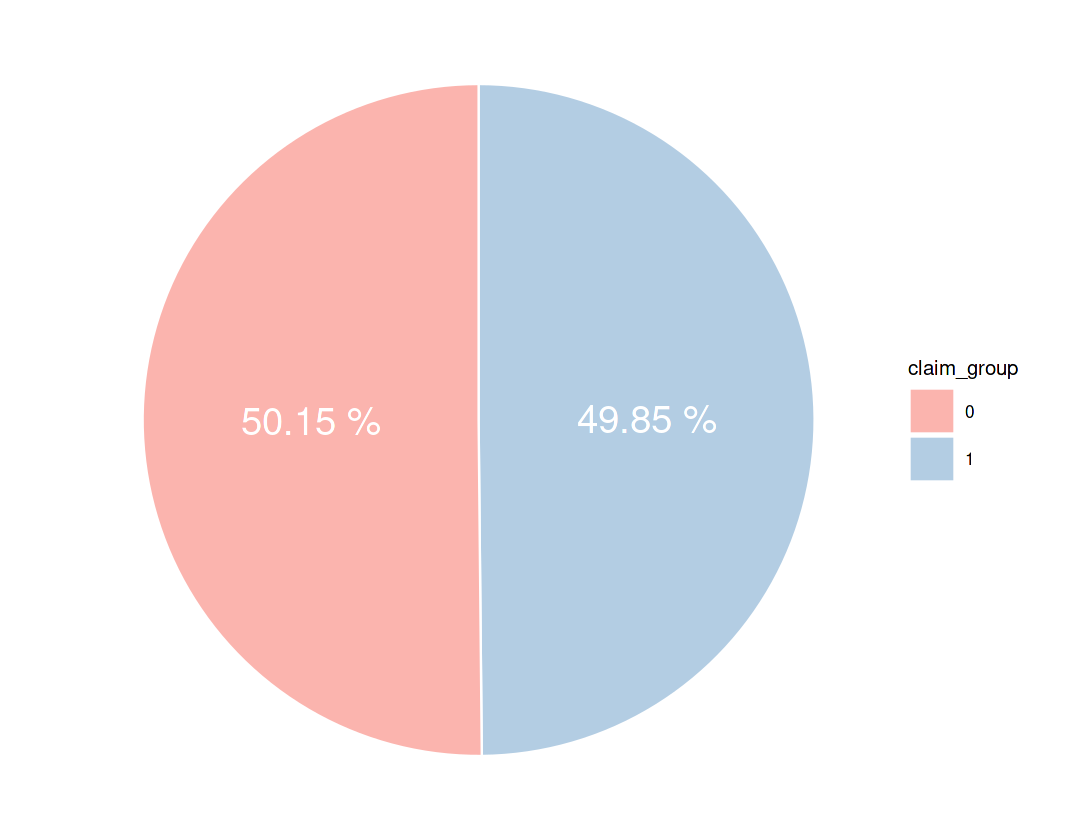

In [5]:
#Piechart
df_pie <- data.frame(claim = c(sum(df_train$claim), (length(df_train$claim) - sum(df_train$claim))), claim_group = c(1,0))

df_pie <- df_pie %>%
    mutate(claim_group = as.factor(claim_group))

#Label positions
df_pie<- df_pie %>% 
  arrange(desc(claim_group)) %>%
  mutate(prop = claim / sum(df_pie$claim) *100) %>%
  mutate(ypos = cumsum(prop)- 0.5*prop)

df_pie <- df_pie %>%
cbind(roundup = round(df_pie$prop, digits = 2))


options(repr.plot.width = 9, repr.plot.height = 7)
# Basic piechart
ggplot(df_pie, aes(x =" ", y = prop, fill = claim_group)) +
  geom_bar(stat="identity", width=2, color="white") +
  coord_polar("y", start=0) +
  theme_void() + 
  geom_text(aes(y = ypos), label = paste(as.character(df_pie$roundup), "%", sep=" "), color = "white", size = 8) +
  scale_fill_brewer(palette = "Pastel1") +
 theme(legend.key.size = unit(1, 'cm'), 
        legend.key.height = unit(1, 'cm'), 
        legend.key.width = unit(1, 'cm'), 
        legend.title = element_text(size = 12), 
        legend.text = element_text(size = 10))




Target label is nearly evenly split.

# Exploring missing data
Since distributions of train and test sets are similar, they will be joined before filling missing values.

In [6]:
#Joining datasets
df_joint <- df_train %>%
    dplyr::select(-claim)

df_joint <- df_joint %>%
    rbind(df_test)

df_joint <- df_joint %>%
    dplyr::select(-id)


#Checking how many cells are missing per column
missing_array <- c()
for(i in 2:length(df_joint)) {
    missing_array[i-1] <- sum(is.na(df_joint[, i]))
}

summary(missing_array)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  22956   23281   23385   23367   23465   23719 

All columns are missing nearly the same number of values.

In [7]:
#Checking how many cells are missing per row
nas_per_row <- c(rep(0, nrow(df_joint)))

for(i in 1:length(df_joint))
nas_per_row <- nas_per_row + as.numeric(is.na(df_joint[[i]]))

summary(nas_per_row)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0     0.0     1.0     1.9     3.0    15.0 

In [8]:
#Distribution of missing rows throughout a column that was split into 10 parts
k <- 1
for(i in seq(from = length(nas_per_row)/10, to = length(nas_per_row), by = length(nas_per_row)/10)) {
    print(sum(nas_per_row[k:i]))
    k <- i
}
#Sums of missing rows throughout partitions of the colum are similar

[1] 274882
[1] 276128
[1] 275690
[1] 275902
[1] 276501
[1] 276023
[1] 276287
[1] 276660
[1] 273370
[1] 275561


Missing values will be filled feature by feature - column by column.

In [9]:
#Normalizing function
df_joint <- BBmisc::normalize(df_joint, method = "range", range = c(-1,1))


#Sampling data for training
splitprop <- 0.25 * nrow(na.omit(df_joint))

set.seed(2022)

split <- sample(nrow(na.omit(df_joint)), splitprop)

Checking the summary of the sampled data frame.

In [10]:
head(na.omit(df_joint)[split, ])
summary(na.omit(df_joint)[split, ])

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,⋯,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
636594,-0.2150362446,0.353508739,0.2322631,-0.8550451,-0.97307065,0.248604583,-0.85051846,-0.8574325,-0.6827289,-0.4541839,⋯,-0.141176117,0.06677559,-0.40727609,-0.7578823,-0.5625588,-0.6998294,0.06389452,0.1477368,0.03987296,-0.6519573
880120,-0.0009149131,0.479942109,-0.6180438,-0.8641063,0.34246603,0.170552760,0.01178469,-0.4167734,-0.7727326,-0.5124710,⋯,-0.007551749,0.90529564,0.04948648,-0.3113375,0.5183332,-0.5336194,-0.34807302,-0.8567180,-0.03531303,-0.4051444
1069263,-0.0019353931,-0.025717148,-0.5860175,-0.8770543,0.69665131,0.184727363,-0.58892664,-0.9594640,-0.4983779,-0.2380697,⋯,-0.510281272,0.47537902,-0.42430838,-0.7547503,-0.3373712,-0.7240530,0.07829615,0.4318046,-0.54485304,-0.3233443
263913,0.1603561123,0.722418080,-0.5115641,-0.6057523,0.63632285,-0.003999501,-0.51852638,0.1077120,-0.7977093,-0.5304801,⋯,0.397352385,0.88184053,-0.38082266,-0.7860286,-0.4632906,-0.7252833,-0.51582150,-0.9442308,-0.53383516,-0.2002757
798051,-0.1965022169,-0.009685679,-0.5341384,-0.7631007,0.29742410,0.177323961,-0.91458860,-0.5120324,-0.7849974,-0.3981201,⋯,-0.463950152,0.59311979,-0.60228892,-0.7672712,-0.1449009,-0.7275900,-0.18661258,-0.8689299,-0.54576385,-0.8697323
373229,-0.1457315786,0.630756671,-0.6271699,-0.8884140,0.07690705,-0.448180344,-0.18073398,-0.8183287,0.5040489,-0.5290302,⋯,-0.145292914,0.61546950,-0.57848083,-0.7620268,-0.3276222,-0.1951443,-0.50608519,-0.8598743,0.26728190,-0.3715263


       f1                 f2                f3                f4         
 Min.   :-1.00000   Min.   :-1.0000   Min.   :-0.9981   Min.   :-0.9784  
 1st Qu.:-0.21344   1st Qu.: 0.1304   1st Qu.:-0.6005   1st Qu.:-0.8329  
 Median :-0.14359   Median : 0.5184   Median :-0.5662   Median :-0.6870  
 Mean   :-0.14264   Mean   : 0.3583   Mean   :-0.4548   Mean   :-0.5951  
 3rd Qu.:-0.04944   3rd Qu.: 0.7749   3rd Qu.:-0.4407   3rd Qu.:-0.4580  
 Max.   : 0.95985   Max.   : 1.0000   Max.   : 0.9620   Max.   : 0.9518  
       f5                f6                 f7                 f8         
 Min.   :-0.9995   Min.   :-0.98145   Min.   :-0.98921   Min.   :-0.9971  
 1st Qu.:-0.1127   1st Qu.:-0.02572   1st Qu.:-0.75182   1st Qu.:-0.8773  
 Median : 0.1956   Median : 0.03551   Median :-0.41183   Median :-0.6737  
 Mean   : 0.1128   Mean   : 0.06079   Mean   :-0.34953   Mean   :-0.5849  
 3rd Qu.: 0.4943   3rd Qu.: 0.14375   3rd Qu.:-0.04063   3rd Qu.:-0.3981  
 Max.   : 0.9833   Max.   : 1.00

Sampled data envelops a decent range of values for each feature.

In [11]:
#Filling missing values with a gbm model

#Filling loop
for(i in 1:length(df_joint)) {
    
   gb_model <- h2o4gpu.gradient_boosting_regressor(loss = 'ls', learning_rate = 0.1, n_estimators = 150, random_state = 1212,
                                                   max_depth = 4, predictor = 'gpu_predictor',
                                                   tree_method = 'gpu_hist', backend = 'h2o4gpu') %>%
   h2o4gpu::fit(na.omit(df_joint)[split, -i], na.omit(df_joint)[split, i])
                                                    

   df_joint[which(is.na(df_joint[, i])), i] <- predict(gb_model, df_joint[which(is.na(df_joint[, i])), -i])
}

#Removing models
rm(gb_model)
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,2730299,145.9,7885907,421.2,12321728,658.1
Vcells,354708686,2706.3,853976422,6515.4,853972228,6515.3


In [12]:
#Checking imputation results
head(df_joint, 20)

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,⋯,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-0.07882328,-0.91325973,-0.6185370,-0.858082113,0.05283966,-0.784552676,-0.87262625,-0.7954838,-0.7182980100,-0.5270653,⋯,-0.73706532,0.74242185,-0.30981608,-0.75888503,-0.47614398,-0.7159475,-0.373427992,-0.9412715,-0.91827087,-0.1778636
2,-0.10588359,0.18258062,-0.1371970,-0.488421722,0.65914599,-0.001483176,-0.31107336,-0.8459998,-0.1265252599,-0.3509078,⋯,0.74806918,-0.08624832,0.81338729,-0.77160456,-0.17329782,-0.7273469,-0.298782961,-0.9010614,-0.66546205,-0.6788668
3,0.16552889,-0.95517126,-0.5801893,-0.494641311,0.65836389,0.082582872,-0.10719468,-0.5981638,-0.7842037143,-0.2460500,⋯,-0.58253106,0.86262275,-0.56228391,-0.77229841,-0.06598338,-0.5819396,-0.440770791,-0.9445028,-0.37500147,-0.5947123
4,0.07519882,-0.90233013,-0.5853507,-0.846933928,0.87162872,0.691336356,-0.88062781,-0.7022623,-0.7730372364,-0.5292671,⋯,-0.94762234,0.32129439,-0.16074868,-0.76795346,-0.72418153,-0.7140607,-0.436713996,-0.9464030,-0.22061900,-0.5210335
5,-0.05193891,0.93698742,-0.6214423,-0.457880119,0.25103126,0.034120534,-0.02194147,-0.9020603,-0.4614906462,-0.5260365,⋯,0.66343470,0.71612697,-0.41117449,-0.76510176,-0.29632368,-0.7176655,0.181135903,-0.9464840,-0.35715652,-0.7151056
6,-0.10366669,-0.93896241,-0.6624166,-0.716948807,0.15845890,0.028374995,-0.08072336,-0.9711506,0.2045402294,-0.3782658,⋯,-0.03009121,0.14964261,0.54087055,-0.55810061,-0.45883302,-0.5837455,-0.438336714,-0.9446348,-0.12377922,-0.8950364
7,-0.45012527,0.40494304,0.2317761,-0.877909619,-0.02213542,-0.033739550,-0.45995682,-0.7293366,-0.4846175461,-0.5294679,⋯,0.01720049,0.22705711,-0.42983112,-0.76391331,0.62007371,-0.6770604,-0.337931034,-0.7991618,-0.79005218,-0.4301908
8,-0.11841087,-0.01669945,-0.1391046,-0.005747413,0.72907297,-0.055483925,0.20465725,-0.8417498,-0.5047982357,-0.5196044,⋯,-0.51177361,0.54205599,-0.39163608,0.05600515,-0.24395125,-0.7266750,-0.297971602,-0.9468477,-0.72118311,-0.6655042
9,-0.49242628,0.32511968,-0.5965643,-0.024777072,-0.04453196,0.129341596,-0.34925859,-0.5494074,-0.6554228152,-0.5285133,⋯,-0.40046571,0.79292364,-0.09196976,-0.78452008,-0.09449601,-0.7269602,-0.384787018,-0.9147455,-0.64972852,-0.7728148


In [13]:
#Adding number of missing rows as a column
df_joint <- df_joint %>%
    cbind(nas_sum = nas_per_row)

# Model creation

Preparing data for modelling and performing a grid search of hyperparameters.

In [14]:
#Isolating training data from the joint dataset
rf_train <- df_joint[1:nrow(df_train), ]

#Adding claim and NAs per row variables to the training set
rf_train <- rf_train %>%
    mutate(claim = df_train$claim)

holdout_prop <- round(0.2 *nrow(rf_train))
holdout_sampler <- sample(nrow(rf_train), holdout_prop)

rf_train_holdout <- rf_train[holdout_sampler, ]

rf_train <- rf_train %>%
    anti_join(rf_train_holdout, by = colnames(rf_train_holdout))


#Removing original train and test sets
rm(df_train, df_test)
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,2734987,146.1,7885907,421.2,12321728,658.1
Vcells,296912617,2265.3,853976422,6515.4,853972228,6515.3


***Grid search***

In [15]:
#Deciding whether to perform a grid search or not
grid_search <- FALSE


if(grid_search == TRUE) {
#Grid search
df_holder <- rf_train
k_grid <- 4

#Splitting holdout set into 10 parts
set.seed(2077)
rf_train <- df_holder %>%
  group_by((row_number()-1) %/% (n()/k_grid)) %>%
  nest %>% pull(data)    

#Isolating holdout
grid_holdout <- rf_train[[k_grid]]

#Merging back list of dataframes
rf_train <- rf_train %>%
    bind_rows()

#Excluding holdout
rf_train <- rf_train %>%
    anti_join(grid_holdout, by = colnames(grid_holdout))



#Brute grid search loops
for(i in c(1)) {
    for(j in c(1)) {
        for(k in c(1)){
    
    
    tic("Creating and fitting the model")

    rf_model_train <- h2o4gpu.random_forest_classifier(n_estimators = 20, criterion = "entropy",
    max_depth = 7, min_samples_split = 3, min_samples_leaf = 1, colsample_bytree = 0.3,
    max_features = "auto", random_state = 1212, subsample = 1, 
    min_impurity_decrease = 2, min_impurity_split = 1, verbose = 0, tree_method = "gpu_hist",
    predictor = "gpu_predictor", backend = "h2o4gpu") %>% fit(x = rf_train[, -length(rf_train)],
                                                              y = rf_train[, length(rf_train)])
    toc()
    
    
    
    
    tic("Predicting on validation data")
    
    grid_pred <- predict(rf_model_train,  grid_holdout[, -(length(grid_holdout))], type = "prob")
    
    toc()
    
    
    cat(sprintf("colsample_bytree: %s\n", i))
    cat(sprintf("subsample: %s\n", j))
    #cat(sprintf("min_samples_leaf: %s\n", k))
    cat(sprintf("Grid search AUC: %s\n",AUC(predictions = grid_pred[, 2], labels = grid_holdout$claim)))

            }
    }
}

    
}

Creating a GPU based random forest classifier model to complement gradient boosting classifier model and NN. Model is checked and developed in a two-step process.
Models are used in a mix similar to [stacking](http://www.kaggle.com/general/18793).
Since it's a GPU based model, other strategies could bring better results and not cause a strain in computation time. 

***Simple cv***

In [16]:
cv <- FALSE

if(cv == TRUE) {
#Splitting data into 10 parts for training
k_cv <- 10

auc_vec <- c()
pred_list <- list()

df_holder <- rf_train
    
for(i in 1:k_cv) {
set.seed(2077)
rf_train <- df_holder %>%
  group_by((row_number()-1) %/% (n()/k_cv)) %>%
  nest %>% pull(data)    

#Isolating holdout
k_inner_holdout <- rf_train[[i]]

#Merging back list of dataframes
rf_train <- rf_train %>%
    bind_rows()


#Excluding inner holdout
rf_train <- rf_train %>%
    anti_join(k_inner_holdout, by = colnames(rf_train))
    
    tic("Creating and fitting the model")

    rf_model_train <- h2o4gpu.random_forest_classifier(n_estimators = 20, criterion = "entropy",
    max_depth = 7, min_samples_split = 3, min_samples_leaf = 1, colsample_bytree = 0.3,
    subsample = 1, random_state = 1212, max_features = "auto",
    verbose = 0, tree_method = "gpu_hist",
    predictor = "gpu_predictor", backend = "h2o4gpu") %>% fit(x = rf_train[, -length(rf_train)],
                                                              y = rf_train[, length(rf_train)])
    toc()
    
    
    
    
    tic("Predicting on validation data")
    
    pred_list[[i]] <- predict(rf_model_train,  k_inner_holdout[, -length(k_inner_holdout)], type = "prob")
    
    toc()

    print(i)
    cat(sprintf("Split AUC: %s\n",AUC(predictions = pred_list[[i]][, 2], labels = k_inner_holdout$claim)))
    auc_vec[i] <- AUC(predictions = pred_list[[i]][, 2], labels = k_inner_holdout$claim)
}

#Mean AUC for CV
cat(sprintf("Mean AUC: %s\n", mean(auc_vec)))



#Removing rf_model
rm(rf_model_train)
gc()

}

1: 
Creating and fitting the model: 5.031 sec elapsed
Predicting on validation data: 0.266 sec elapsed
Split AUC: 0.807258974201438

2: 
Creating and fitting the model: 3.455 sec elapsed
Predicting on validation data: 0.253 sec elapsed
Split AUC: 0.806473453160845

3:
Creating and fitting the model: 3.398 sec elapsed
Predicting on validation data: 0.226 sec elapsed
Split AUC: 0.805474566846782

4:
Creating and fitting the model: 2.943 sec elapsed
Predicting on validation data: 0.211 sec elapsed
Split AUC: 0.802924746024181

5:
Creating and fitting the model: 2.613 sec elapsed
Predicting on validation data: 0.199 sec elapsed
Split AUC: 0.806402562997926

6:
Creating and fitting the model: 2.398 sec elapsed
Predicting on validation data: 0.177 sec elapsed
Split AUC: 0.805294984207043

7:
Creating and fitting the model: 2.225 sec elapsed
Predicting on validation data: 0.168 sec elapsed
Split AUC: 0.804420483910461

8:
Creating and fitting the model: 2.012 sec elapsed
Predicting on validation data: 0.164 sec elapsed
Split AUC: 0.806963979164778

9:
Creating and fitting the model: 1.69 sec elapsed
Predicting on validation data: 0.143 sec elapsed
Split AUC: 0.80400435784427

10:
Creating and fitting the model: 1.394 sec elapsed
Predicting on validation data: 0.132 sec elapsed
Split AUC: 0.802016595796033


Mean AUC: **0.805123470415376**

# Impure CV predictions function

Function generates semi-out-of-fold predictions. Data is split into n parts and k parts out of those n are chosen as holdout. Final predictions share half the knowledge of holdout data with one another.

In [17]:
impure_cv_predictor <- function(dataset, model, package, test, is_validation) {
    #Spltting the data and setting up cv
k_num <- 10

temp_dataset <- dataset

combinations <- combn(rep(1:10), 2)
list_comb <- lapply(seq_len(ncol(combinations)), function(i) combinations[,i])

predictions <- list()


df_of_predictions <- data.frame(id = 1:nrow(test))                    

#Pseudo cv loop
for(i in 1:length(list_comb)) {

set.seed(2040)
dataset <- temp_dataset %>%
  group_by((row_number()-1) %/% (n()/k_num)) %>%
  nest %>% pull(data)

temp_exclusion <- dataset[[list_comb[[i]][1]]] %>%
    rbind(dataset[[list_comb[[i]][2]]])
    
    dataset <- dataset %>%
        bind_rows()
    
dataset <- dataset %>%
    anti_join(temp_exclusion, by = colnames(dataset))
    
    
    if(package == 'keras'){
        
        if(is_validation == TRUE) {
        model %>% keras::fit(
  x = list(data.matrix(dataset[, length(dataset)-1], rownames.force = NA),
           data.matrix(dataset[, -c((length(dataset)-1):length(dataset))], rownames.force = NA)),
  data.matrix(dataset[, length(dataset)], rownames.force = NA),
  epochs = 10,
  batch_size = 478)
        
        
    predictions <- predict(model, list(data.matrix(test[, length(test)-1],
                                                               rownames.force = NA),
                                         data.matrix(test[, -c((length(test)-1):length(test))],
                                                               rownames.force = NA)))
     df_of_predictions <- df_of_predictions %>%
        cbind(predictions)
        
        
        
        }
         if(is_validation == FALSE) {
        
                model %>% keras::fit(
  x = list(data.matrix(dataset[, length(dataset)-1], rownames.force = NA),
           data.matrix(dataset[, -c((length(dataset)-1):length(dataset))], rownames.force = NA)),
  data.matrix(dataset[, length(dataset)], rownames.force = NA),
  epochs = 10,
  batch_size = 478)
        
        
    predictions <- predict(model, list(data.matrix(test[, length(test)],
                                                               rownames.force = NA),
                                         data.matrix(test[, -length(test)],
                                                               rownames.force = NA)))
     df_of_predictions <- df_of_predictions %>%
        cbind(predictions)
        
    }
    
        }
    
    if(package == 'h2o4gpu') {
        
        if(is_validation == TRUE) {
        model_fit <- model %>% h2o4gpu::fit(x = dataset[, -length(dataset)],
                                   y = dataset[, length(dataset)])
        
        predictions <- predict(model_fit, test[, -length(test)], type = "prob")
    
        df_of_predictions <- df_of_predictions %>%
            cbind(predictions)
        
                            }
    
        if(is_validation == FALSE) {
           model_fit <- model %>% h2o4gpu::fit(x = dataset[, -length(dataset)],
                                   y = dataset[, length(dataset)])
        
           predictions <- predict(model_fit, test, type = "prob")
    
           df_of_predictions <- df_of_predictions %>%
              cbind(predictions)
        
        }
}
    
    }

df_of_predictions <- df_of_predictions[, -1]
       
return(df_of_predictions)       
                                        }

***Random forest model***

In [18]:
#Predicting with rf on test and holdout data - model assembly

       rf_model <- h2o4gpu.random_forest_classifier(n_estimators = 20, criterion = "entropy",
    max_depth = 7, min_samples_split = 3, min_samples_leaf = 1, colsample_bytree = 0.3,
    max_features = "auto", random_state = 1212, subsample = 1, 
    min_impurity_decrease = 2, min_impurity_split = 1, verbose = 0, tree_method = "gpu_hist",
    predictor = "gpu_predictor", backend = "h2o4gpu")

rf_validation_pred <- impure_cv_predictor(dataset = rf_train, model = rf_model,
                                         package = 'h2o4gpu', test = rf_train_holdout, is_validation = TRUE)

rf_test_pred <- impure_cv_predictor(dataset = rf_train, model = rf_model, package = 'h2o4gpu',
                                    test = df_joint[957919:nrow(df_joint), ], is_validation = FALSE)

#Removing used model
rm(rf_model)
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,2749431,146.9,7885907,421.2,12321728,658.1
Vcells,358607753,2736.0,853976422,6515.4,853972228,6515.3


**Gradient boosting classifier**

In [20]:
#Predicting with gb on test and holdout data - model assembly

    gb_model_class <- h2o4gpu.gradient_boosting_classifier(loss = "deviance", learning_rate = 0.3,
                n_estimators = 200, subsample = 1, criterion = "friedman_mse",
                min_samples_split = 2, min_samples_leaf = 1,
                min_weight_fraction_leaf = 0, max_depth = 5, min_impurity_decrease = 0,random_state = 1212,
                max_features = "auto", verbose = 0,
                warm_start = FALSE, presort = "auto", colsample_bytree = 0.21,
                tree_method = "gpu_hist", 
                predictor = "gpu_predictor", objective = "binary:logistic",
                booster = "gbtree", gamma = 0, colsample_bylevel = 1, reg_alpha = 0,
                reg_lambda = 1, scale_pos_weight = 1, base_score = 0.5,
                backend = "h2o4gpu")


gb_validation_pred <- impure_cv_predictor(dataset = rf_train, model = gb_model_class,
                                         package = 'h2o4gpu', test = rf_train_holdout, is_validation = TRUE)

gb_test_pred <- impure_cv_predictor(dataset = rf_train, model = gb_model_class, package = 'h2o4gpu',
                                    test = df_joint[957919:nrow(df_joint), ], is_validation = FALSE)

#Removing used model
rm(gb_model_class)
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,2751019,147.0,7885907,421.2,12321728,658.1
Vcells,420266958,3206.4,1024851706,7819.0,1024851235,7819.0


In [21]:
#NN model
features_input <- layer_input(shape = c(dim(rf_train)[[-1]]-2), name = 'features_input')

nas_input <- layer_input(shape = c(1), name = 'nas_input')


features_output <- features_input %>%
    layer_dense(units = 48, activation = 'hard_sigmoid') %>%
    layer_dropout(rate = 0.3) %>%
    layer_dense(units = 32, activation = 'hard_sigmoid') %>%
    layer_dropout(rate = 0.3) %>%
    layer_dense(units = 24, activation = 'hard_sigmoid') %>%
    layer_dropout(rate = 0.3) %>%
    layer_dense(units = 16, activation = 'hard_sigmoid') %>%
    layer_batch_normalization(
    momentum = 0.99,
    epsilon = 0.001,
    center = TRUE,
    scale = TRUE) %>%
    layer_flatten()

nas_output <- nas_input %>%
    layer_dense(units = 48, activation = 'hard_sigmoid') %>%
    layer_dropout(rate = 0.18) %>%
    layer_dense(units = 32, activation = 'hard_sigmoid') %>%
    layer_dropout(rate = 0.18) %>%
    layer_dense(units = 32, activation = 'hard_sigmoid') %>%
    layer_dropout(rate = 0.18) %>%
    layer_dense(units = 16, activation = 'hard_sigmoid')


nn_output <- layer_concatenate(c(nas_output, features_output)) %>%
    layer_dense(units = 32, activation = 'hard_sigmoid') %>%
    layer_dense(units = 16, activation = 'hard_sigmoid') %>%
    layer_dense(units = 16, activation = 'hard_sigmoid') %>%
    layer_dense(units = 1, activation = 'hard_sigmoid', name = 'nn_output')



nn_model <- keras_model(
        inputs = c(nas_input, features_input),
        outputs = c(nn_output))


nn_model %>% compile(
  optimizer = 'adam',
  loss = "binary_crossentropy",
  metrics = 'AUC')


nn_model %>% summary()

Model: "functional_1"
________________________________________________________________________________
Layer (type)              Output Shape      Param #  Connected to               
features_input (InputLaye [(None, 118)]     0                                   
________________________________________________________________________________
dense_3 (Dense)           (None, 48)        5712     features_input[0][0]       
________________________________________________________________________________
nas_input (InputLayer)    [(None, 1)]       0                                   
________________________________________________________________________________
dropout_2 (Dropout)       (None, 48)        0        dense_3[0][0]              
________________________________________________________________________________
dense_7 (Dense)           (None, 48)        96       nas_input[0][0]            
________________________________________________________________________________
dense_

In [ ]:
#Neural network predictions

nn_validation_pred <- impure_cv_predictor(dataset = rf_train, model = nn_model, package = 'keras',
                                          is_validation = TRUE, test = rf_train_holdout)

nn_test_pred <- impure_cv_predictor(dataset = rf_train, model = nn_model, package = 'keras',
                                    test = df_joint[957919:nrow(df_joint), ], is_validation = FALSE)


In [ ]:
#Second level model - NN with concatenated layers

rf_input <- layer_input(shape = c(dim(rf_predictions_df)[[-1]]), name = 'rf_input')

gb_input <- layer_input(shape = c(dim(gb_predictions_df)[[-1]]), name = 'gb_input')

nn_input <- layer_input(shape = c(dim(nn_predictions_df)[[-1]]), name = 'nn_input')                     

rf_output <- rf_input %>%
    layer_dense(units = 24, activation = 'sigmoid') %>%
    layer_dropout(rate = 0.2) %>%
    layer_dense(units = 16, activation = 'sigmoid') %>%
    layer_dropout(rate = 0.2) %>%
    layer_dense(units = 12, activation = 'sigmoid') %>%
    layer_dropout(rate = 0.2) %>%
    layer_dense(units = 8, activation = 'sigmoid') %>%
    layer_batch_normalization(
    momentum = 0.99,
    epsilon = 0.001,
    center = TRUE,
    scale = TRUE)
                        
                        
gb_output <- gb_input %>%
    layer_dense(units = 24, activation = 'sigmoid') %>%
    layer_dropout(rate = 0.15) %>%
    layer_dense(units = 16, activation = 'sigmoid') %>%
    layer_dropout(rate = 0.15) %>%
    layer_dense(units = 16, activation = 'sigmoid') %>%
    layer_dropout(rate = 0.15) %>%
    layer_dense(units = 8, activation = 'sigmoid') %>%
    layer_batch_normalization(
    momentum = 0.99,
    epsilon = 0.001,
    center = TRUE,
    scale = TRUE)

nn_concat_output <- nn_input %>%
    layer_dense(units = 16, activation = 'sigmoid') %>%
    layer_dropout(rate = 0.25) %>%
    layer_dense(units = 12, activation = 'sigmoid') %>%
    layer_dropout(rate = 0.25) %>%
    layer_dense(units = 8, activation = 'sigmoid') %>%
    layer_dropout(rate = 0.25) %>%
    layer_dense(units = 4, activation = 'sigmoid') %>%
    layer_batch_normalization(
    momentum = 0.99,
    epsilon = 0.001,
    center = TRUE,
    scale = TRUE)

                        
conc_output <- layer_concatenate(c(rf_output, gb_output, nn_concat_output)) %>%
    layer_dense(units = 16, activation = 'sigmoid') %>%
    layer_dense(units = 12, activation = 'sigmoid') %>%
    layer_dense(units = 4, activation = 'sigmoid') %>%
    layer_dense(units = 1, activation = 'sigmoid', name = 'conc_output')
                        
                        

conc_model <- keras_model(
        inputs = c(rf_input, gb_input, nn_input),
        outputs = c(conc_output))


conc_model %>% compile(
  optimizer = 'adam',
  loss = "binary_crossentropy",
  metrics = 'AUC')

In [ ]:
#Fitting the model
conc_history <- conc_model %>% keras::fit(
  x = list(data.matrix(rf_validation_pred, rownames.force = NA),
           data.matrix(gb_validation_pred, rownames.force = NA),
           data.matrix(nn_validation_pred, rownames.force = NA)),
  data.matrix(rf_train_holdout[, length(rf_train_holdout)], rownames.force = NA),
  epochs = 10,
  batch_size = 128)

In [ ]:
#Predicting on 'predicted' data
conc_nn_pred <- predict(conc_model, list(data.matrix(rf_test_pred, rownames.force = NA),
                                    data.matrix(gb_test_pred, rownames.force = NA),
                                    data.matrix(nn_test_pred, rownames.force = NA)))

In [ ]:
#Creating a df for submission
df_pred <- data.frame(id = 957919:1451392, claim = conc_nn_pred)


#Creating a submission file
write.csv(df_pred, "./conc_nn_submission.csv", quote = FALSE, row.names = FALSE)